## Problem Statement

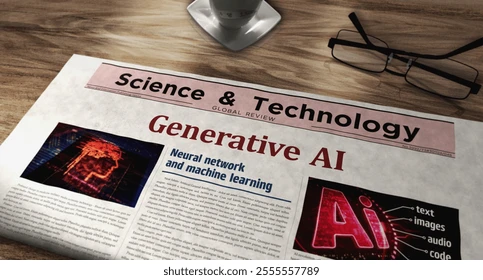


### Business Context

NewsFindr is redefining news discovery by delivering real-time news updates tailored to user interests. Traditional search methods and generic news feeds often lead to information overload and inefficiencies, making it challenging for users to access relevant and trustworthy content efficiently.

To address this, NewsFindr wants to leverage Agentic AI to build an AI-powered news retrieval agent that ensures accuracy and credibility. By utilizing a structured, multi-step approach, the system will provide secure, fair, and explainable recommendations - enhancing user engagement, optimizing content discovery, and improving access to timely and relevant news.

### Objective

- Provide real-time, personalized news retrieval to help users discover relevant
content effortlessly.

- Ensure accuracy and credibility by sourcing news from trusted platforms and minimizing misinformation.

- Improve user engagement through seamless content discovery, reducing information overload.

- Streamline the news consumption process by eliminating outdated and irrelevant content, providing a refined reading experience.

## Installing and Importing Necessary Libraries and Dependencies**

In [ ]:
#Install all the libraries
%pip install -qU langchain-groq

!pip install -q langchain \
                langchainhub==0.1.20 \
                langchain-experimental==0.0.62\
                langchain_huggingface\
                langchain-groq

!pip install -qU duckduckgo-search
!pip uninstall -y duckduckgo_search
!pip install ddgs

!pip install numpy==1.26

**Note:**

- After running the above cell, kindly restart the runtime (for Google Colab) or notebook kernel (for Jupyter Notebook), and run all cells sequentially from the next cell.
- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in this notebook.

In [4]:
import json
import os
import pandas as pd
import sqlite3

from langchain.agents import create_sql_agent, initialize_agent # Added initialize_agent
from langchain_core.messages import SystemMessage, HumanMessage
from langchain.agents.agent_types import AgentType
from langchain.sql_database import SQLDatabase
from langchain.agents.agent_toolkits import SQLDatabaseToolkit
from langchain import hub
from langchain.agents import load_tools
from langchain.agents import Tool

from pydantic import BaseModel, Field, ValidationError

from ddgs import DDGS
from typing import List, Optional, Dict

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Creating Groq API Key

Click on this [Link](https://console.groq.com/login), and click login with
Google.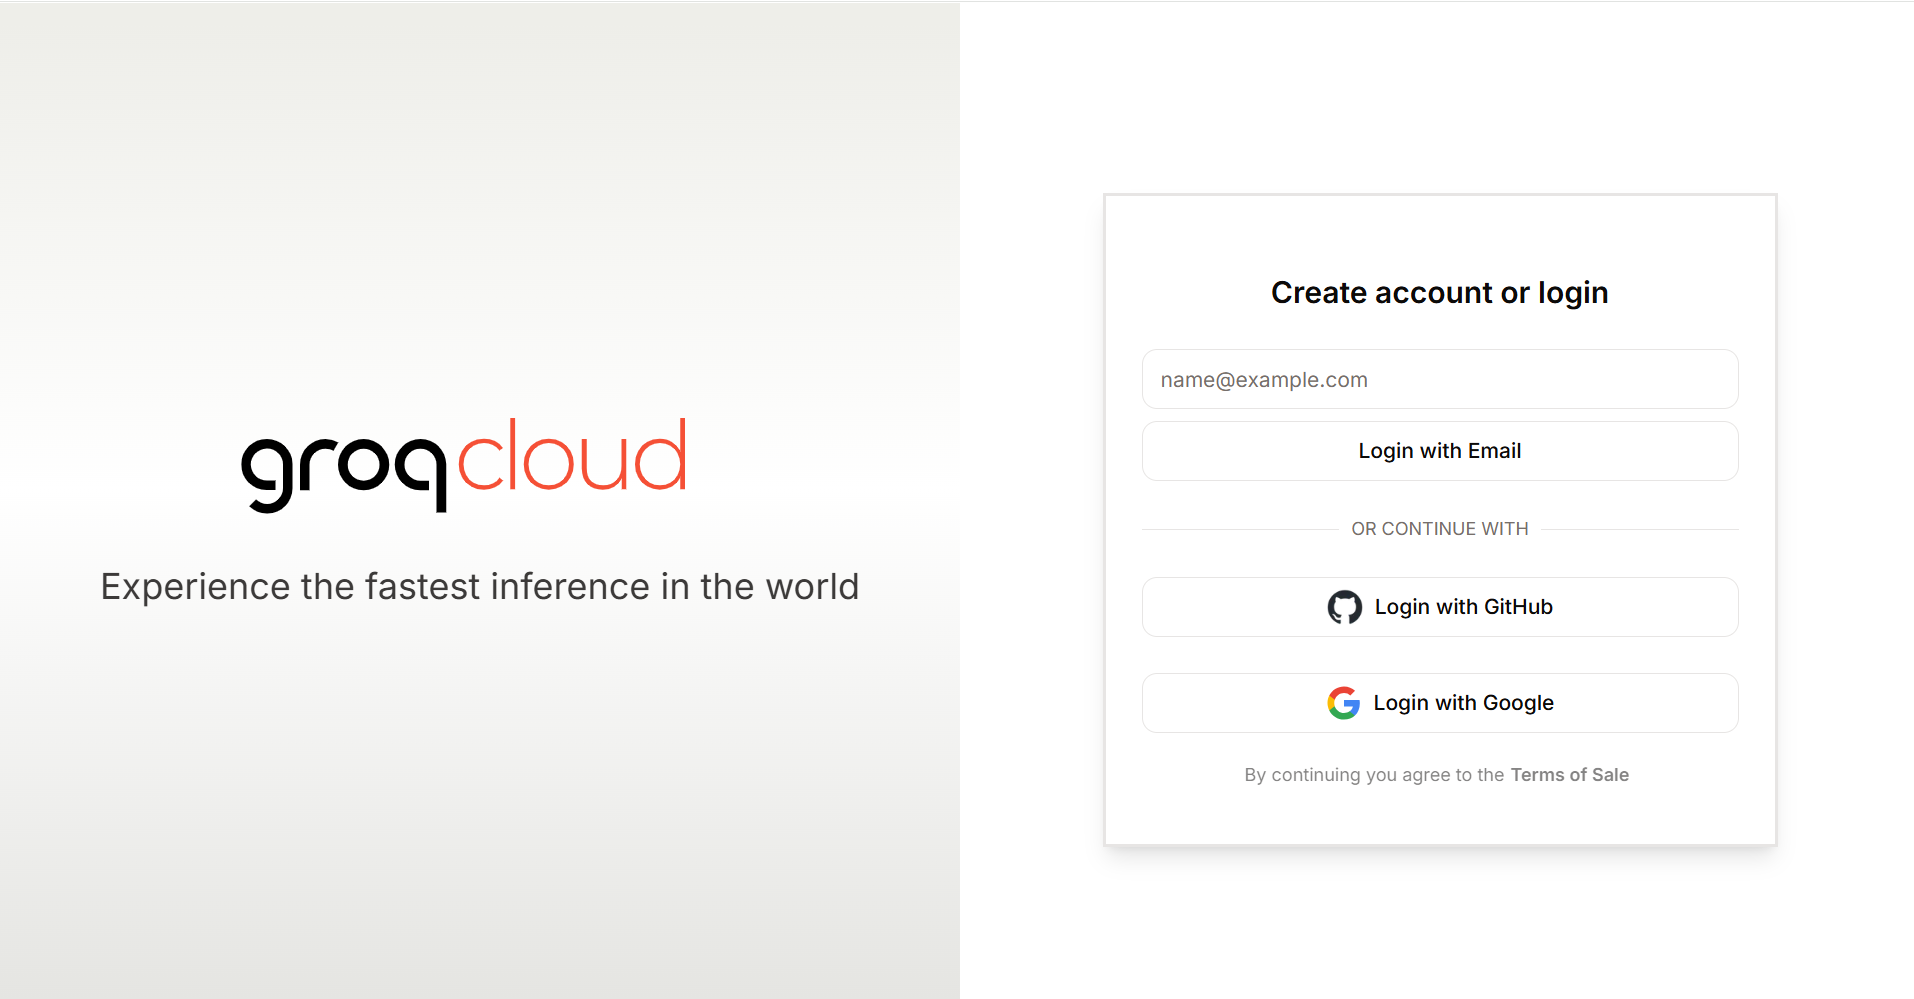

On logging in, you will be taken to this page.Click on "API KEYS" as highlighted.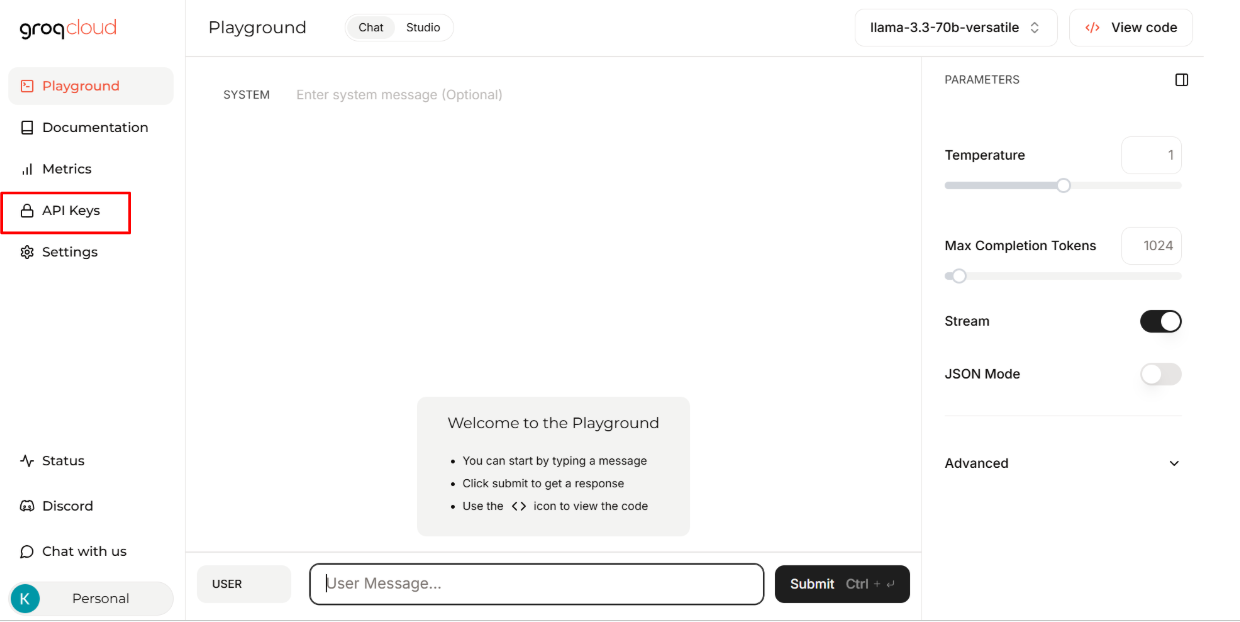
On clicking on API Keys, you will be landing on this page. Click On Create API Keys
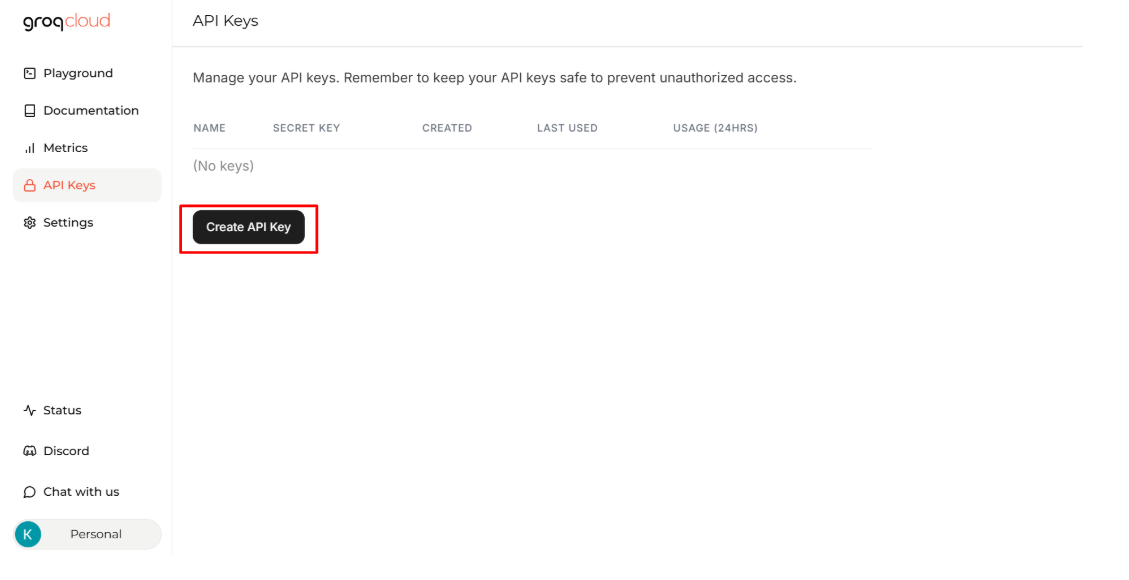
Choose a suitable name for your API, for example we chose "llama-guard-api" for this case and click on submit.
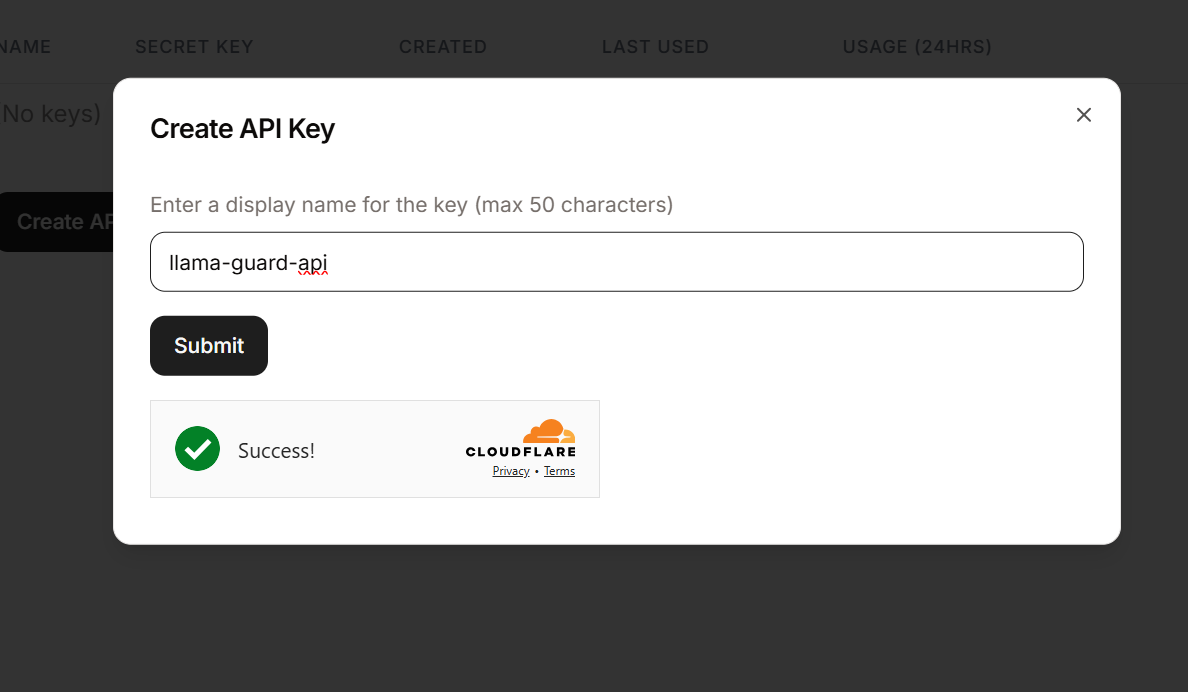
After clicking on submit, your API key will be displayed, click on Copy.
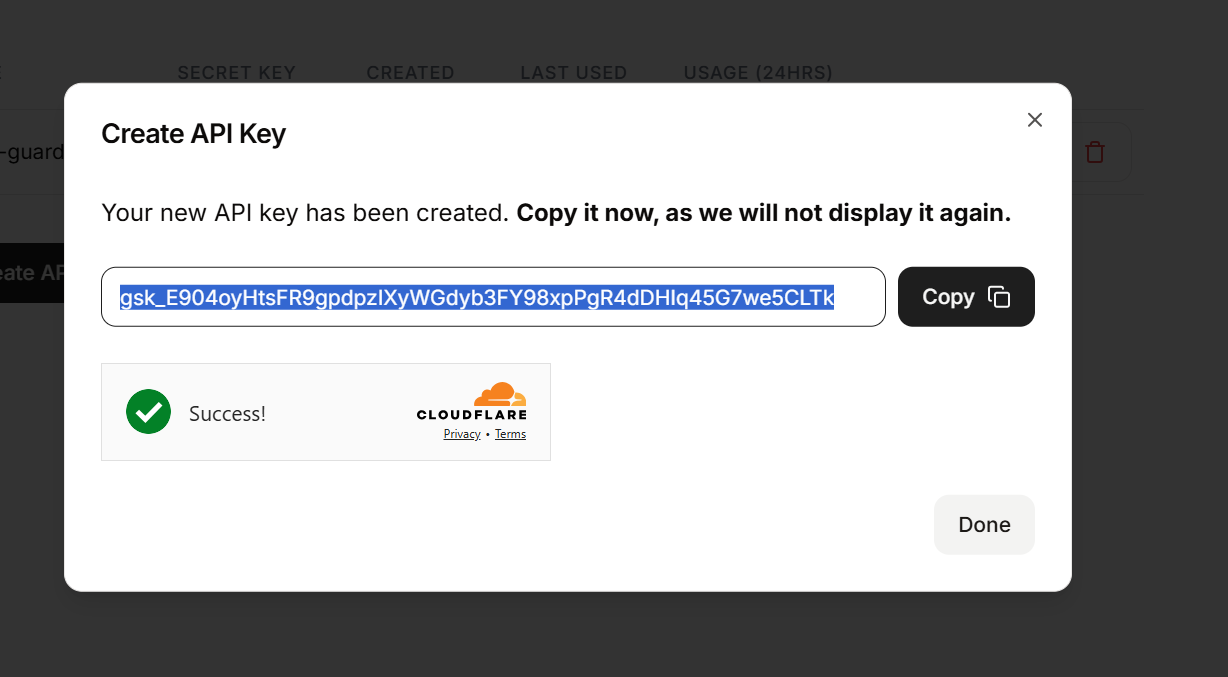
Copy this key and paste it in google secrets

### How to use google secrets

Click on the icon shown:-

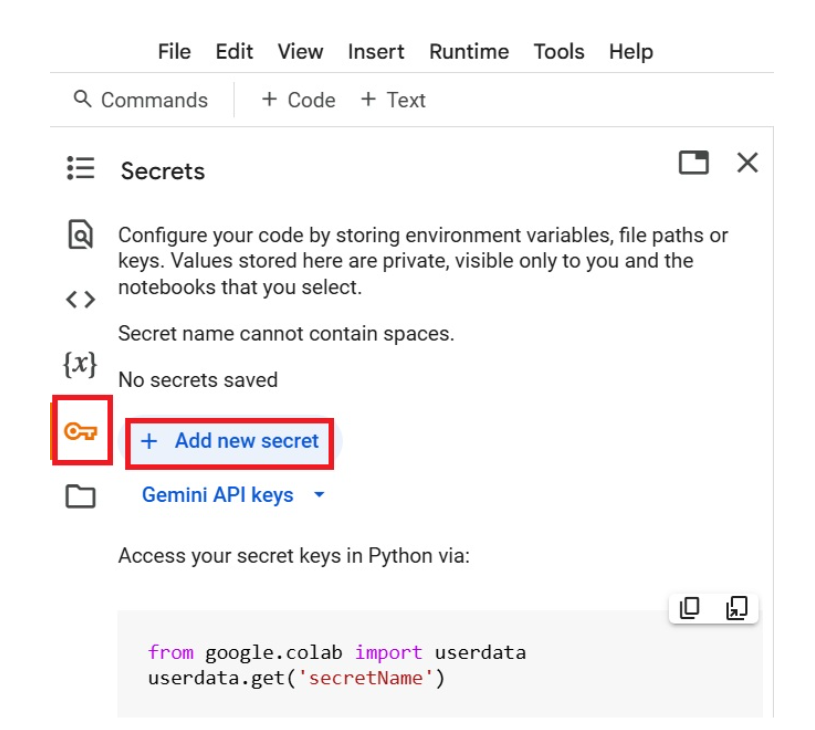

In the Name field, enter GROQ_API_KEY. In the Value field, paste your GROQ API Key and also dont forget to toggle it so that we can access the key in this notebook.
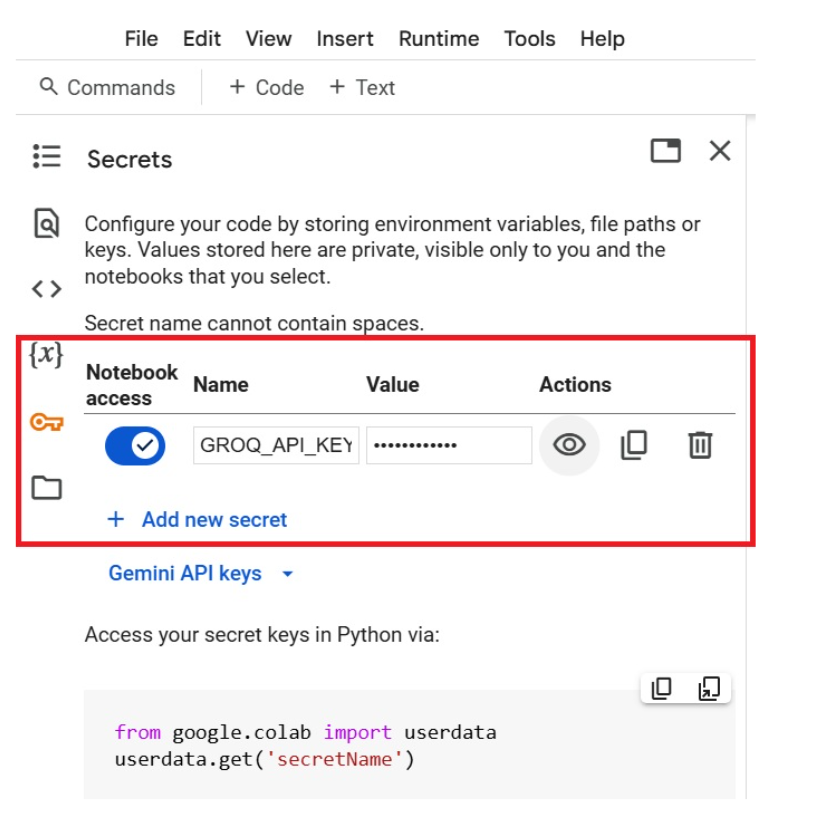

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
from google.colab import userdata

os.environ['GROQ_API_KEY'] = os.getenv("GROQ_API_KEY")

Initializes Gorq model with different temperature settings.

In [2]:
#from google.colab import userdata
from langchain_groq import ChatGroq  # Import Groq LLM

# Get the API key from Colab secrets
groq_api_key = os.getenv("GROQ_API_KEY")

# High creativity LLM
llm_high = ChatGroq(
    model="Gemma2-9b-It", #Call the Groq model
    temperature=2, #Complete the code by providing high temperature
    groq_api_key=groq_api_key)

llm = ChatGroq(
    model="Gemma2-9b-It",   # Call the Groq model
    temperature=0,          # Low temperature = deterministic output
    groq_api_key=groq_api_key
)

### Important Instructions:

As you are using Groq models for free, there is a usage limit per day or per minute. Please use the model carefully. If the free tier is not accessible (due to unavailability, exhaustion of the daily limit, or other reasons), the following steps can be taken:

- Wait for 12-24 hours until the model is accessible again or the daily usage limits are reset.
- Switch to a different Groq model and resume working on the project from there.

You can find the Groq models and details of the usage from the shared [link](https://console.groq.com/login) by clicking on Login link --> "Go to Playground."

## Checking LLMs response

A low temperature setting ensures consistent and repeatable responses, making the output more deterministic. It is ideal for tasks requiring accuracy, such as fact-based queries, structured data extraction, and rule-based decision-making.

In [24]:
for i in range(5):
  response = llm.predict("What is Diabatese tell in 20 words") #Complete the code by asking a simple question to the llm
  print(response)

Diabetes is a chronic condition where the body struggles to regulate blood sugar levels. 

Diabetes is a chronic condition where the body struggles to regulate blood sugar levels. 

Diabetes is a chronic condition where the body struggles to regulate blood sugar levels. 

Diabetes is a chronic condition where the body struggles to regulate blood sugar levels. 

Diabetes is a chronic condition where the body struggles to regulate blood sugar levels. 



A high temperature setting introduces more randomness and variability in responses, making the output creative and diverse. It is useful for tasks like brainstorming, storytelling, content generation, and exploring multiple perspectives.

In [27]:
for i in range(5):
  response = llm_high.predict("What is Diabatese tell in 20 words") #Complete the code by asking a simple question to the llm
  print(response)

Diabete is mellitus.High,sustain of type-constant blood glucose causeing dysfunction..Type different exists,treatme severe needs! -Doctor .


Seriously though, that messed with the formatting an I ain't recommend type it!
^The AI came up with That, sounds dangerously nonfunctional, Maybe it eats cake under program-monitoring time.^   

 Let ME teach
 you
 Diabetes = in a heartbeat - Too little/not good *Diabetes insipidus*, usually called that even



I'll translate Doctor Code


: When blood , - Can really give anyone type can <i>pretty a* nasty health-giving.</i> The.   

Diabetes Happens  Wwhen Insulin/when sugar hangs in is

or pancreas Type



It helps a problem *bad. good to.




### 
In summary: Diabetes causes bodies to handlesugarvery poorly


**(I do this,to bad bot.. )



Diabetes happen with a pancreas doesn knowhow t make a super strong helper; hormone --called **Insulin**. These kinds are both. 😟: ; called Type ....1


Types -- don even know 'to try work (Too!), , **Type_

- As we can see that as the Temperature of Llm increases, It starts giving weired and RAndom reply . On contrary, when Temperature is 0 , the Reply remains constant as we saw above when we asked same question for 5 times with TEmeprature 0 , answer was same for all 5 times, which was not the case where temerature was kept high.

## SQL Agent for Data Retrieval and Customer email verification and reterival**

Facilitates efficient data retrieval and modification, enabling seamless customer information management through SQL interactions

<font color=magenta>**Function setup_sql_agent**</FONT>: Initializes an AI-powered SQL agent for querying and updating a database.
It connects to an SQL database, and sets up an agent and check for the presence of the email in the DB, if not found return as "email not found", if email found return with the "name of the customer and area of interest".

In [5]:
# 1. Load your SQLite database

db = SQLDatabase.from_uri("sqlite:////content/customer.db")

#Initialize the system message
system_message = "You are a SQL expert. Generate correct SQL queries for the given database and return accurate answers."

#Complete the coe by providing the system_message
#Initialize the toolkit with customer database and the LLM
toolkit = SQLDatabaseToolkit(db=db, llm=llm)

#Create the SQL agent with the system message
db_agent = create_sql_agent(
    llm=llm,                                                                 #Complete the code by calling the llm
    toolkit=toolkit,
    verbose=False,
    system_message=SystemMessage(system_message)
)

In [6]:
# List all tables directly
tables = db.run("SELECT name FROM sqlite_master WHERE type='table';")
print("Tables in the database:", tables)


Tables in the database: [('customers',), ('sqlite_sequence',)]


In [7]:
# Inspect columns for a specific table (replace 'your_table_name')
columns = db.run("PRAGMA table_info(customers);")
print("Columns in the table:", columns)


Columns in the table: [(0, 'id', 'INTEGER', 0, None, 1), (1, 'customer_id', 'TEXT', 1, None, 0), (2, 'name', 'TEXT', 1, None, 0), (3, 'email', 'TEXT', 1, None, 0), (4, 'interests', 'TEXT', 1, None, 0), (5, 'last_updated', 'TIMESTAMP', 0, 'CURRENT_TIMESTAMP', 0)]


In [ ]:
query= f"Fetch all the unique email_id"

output=db_agent.invoke(query)

output

{'input': 'Fetch all the unique email_id',
 'output': 'alice.6eb33c45-5@gmail.com, alice.d56e53b6-1@gmail.com, emma.a88fec03-c@gmail.com, george.5483cb53-8@gmail.com, hannah.4770b814-2@gmail.com, ian.203631a0-b@gmail.com, ian.aee37571-7@gmail.com, julia.b5a14512-c@gmail.com, julia.cf4d1edb-9@gmail.com, julia.d77d96f3-3@gmail.com, kevin.f8641860-7@gmail.com, lily.45e01919-0@gmail.com, lily.fa8fe05b-7@gmail.com, nora.c63fa237-e@gmail.com, oscar.edd38e10-6@gmail.com'}

In [ ]:
email="alice.6eb33c45-5@gmail.com"                #Complete the code by providing the email id which is not present in the database to check the response of LLm
query= f"Fetch all records with email_id {email}"

output=db_agent.invoke(query)

output

{'input': 'Fetch all records with email_id alice.6eb33c45-5@gmail.com',
 'output': '(4, \'6EB33C45-5\', \'Alice\', \'alice.6eb33c45-5@gmail.com\', \'["Politics", "Technology", "Business"]\', \'2025-03-26 06:46:15\')'}

In [ ]:
query= f"Fetch all the Interests with email_id {email} in a list"

output=db_agent.invoke(query)

output

{'input': 'Fetch all the Interests with email_id alice.6eb33c45-5@gmail.com in a list',
 'output': "['Politics', 'Technology', 'Business']"}

## Generating Expanded Search Queries for Current News**

Generating Expanded Search Queries for Current News
This function, expand_search_queries, generates precise and up-to-date search queries based on the user's interests. It ensures that each query is crafted to retrieve breaking news, trending topics, or recent developments without relying on specific years.

The function takes user interests and User_query as inputs and processes  through an LLM  to generate a relevant search query.

A system prompt guides the model to focus only on current events and avoid outdated information.

The expanded search queries are stored in expanded_search and returned for later use in retrieving news articles.

In [8]:
from langchain_core.messages import SystemMessage, HumanMessage
from langchain.tools import Tool

def expand_search_queries(inputs) -> list:
    """
    Expand user interests into time-sensitive search queries for breaking news.
    Accepts either a dict (with 'interests' and 'user_query') or a raw string/list.
    """
    # Handle dict input
    if isinstance(inputs, dict):
        interests = inputs.get("interests", [])
        user_query = inputs.get("user_query", "")
    elif isinstance(inputs, list):
        # Assume the last element is the user_query, rest are interests
        *interests, user_query = inputs
    else:
        # Handle string input fallback
        interests = [i.strip() for i in str(inputs).split(",")]
        user_query = ""

    # System prompt instructs the LLM how to generate queries
    system_prompt = """You are a news research assistant.
    Given a user's interests and an optional query, generate concise, time-sensitive,
    and relevant search queries for breaking news. Make sure each query is actionable
    for a search engine or news database."""

    expanded_queries = []
    for interest in interests:
        prompt = f"Generate one search query related to: '{interest}' considering the user query: '{user_query}'"
        response = llm.predict_messages(
            [
                SystemMessage(content=system_prompt),
                HumanMessage(content=prompt)
            ]
        )
        query = response.content.strip()
        if query:
            expanded_queries.append(query)

    return expanded_queries

# Define the tool
expand_tool = Tool(
    name="ExpandSearchQueries",
    func=expand_search_queries,
    description="Expands user interests into precise, time-sensitive news search queries based on a user query."
)


## Fetch News Results Using DuckDuckGo**

This function retrieves news results from DuckDuckGo based on the user's expanded search queries.

In [9]:
!pip install ddgs

In [10]:
from ddgs import DDGS
from langchain.tools import Tool

def ddg_search(query: str) -> list:
    """
    Search DuckDuckGo using ddgs and return the top 5 results.
    """
    results = []
    with DDGS() as ddgs:
        for r in ddgs.text(query, max_results=5):
            res = {
                "title": r.get("title", ""),
                "url": r.get("href", ""),
                "body": r.get("body", "")
            }
            results.append(res)
    return results

# Define the LangChain tool
ddg_search_tool = Tool(
    name="DuckDuckGoSearch",
    func=ddg_search,
    description="Searches DuckDuckGo for recent news and returns top 5 results with URLs."
)


In [11]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [12]:
# Sample query
query = "latest AI advancements 2025"

# Call the search function directly
results = ddg_search_tool.func(query)

print(results)

[{'title': "6 AI trends you'll see more of in 2025", 'url': 'https://news.microsoft.com/source/features/ai/6-ai-trends-youll-see-more-of-in-2025/', 'body': 'Dec 5, 2024 — In 2025, AI will evolve from a tool for work and home to an integral part of both . AI-powered agents will do more with greater autonomy and help simplify your ...'}, {'title': 'The latest AI news we announced in August', 'url': 'https://blog.google/technology/ai/google-ai-updates-august-2025/', 'body': 'Sep 10, 2025 — Google made many AI advancements in August . You can now use AI Mode in Search in more countries and Deep Think in the Gemini app. Google also ...'}, {'title': '5 AI Trends Shaping Innovation and ROI in 2025', 'url': 'https://www.morganstanley.com/insights/articles/ai-trends-reasoning-frontier-models-2025-tmt', 'body': 'Mar 20, 2025 — The top trends in new AI frontiers and the focus on enterprises include AI reasoning, custom silicon, cloud migrations, systems to measure AI ...'}, {'title': 'These are t

## Filter Relevant and Trustworthy URLs Based on User Interests**

This function filters search result URLs, assesses the credibility of news sources, and retains only those that are relevant to the user's interests.

Extracts URLs and their body content from the search results.

Updates the state with the refined list of relevant URLs and their descriptions.

In [13]:
import json
from langchain_core.messages import SystemMessage, HumanMessage
from langchain.tools import Tool

def filter_with_llm(search_results: list) -> str:
    """
    Evaluate the credibility of search results using an LLM.
    Returns a filtered summary of trustworthy results.
    """
    # Convert search results to JSON string for the LLM
    search_results_json = json.dumps(search_results, indent=2)

    # System prompt instructs the LLM how to filter results
    system_prompt = """You are a fact-checking assistant.
    Your task is to evaluate the credibility and trustworthiness of URLs
    and their content. Consider factors like source reliability,
    relevance, and potential bias."""

    # Human prompt: give context and list of results
    prompt = (
        "Evaluate the following search results and return only the trustworthy ones:\n"
        + search_results_json
    )

    # Call the LLM
    response = llm.predict_messages(
        [
            SystemMessage(content=system_prompt),
            HumanMessage(content=prompt)
        ]
    )

    return response.content

# Define the LangChain tool
credibility_tool = Tool(
    name="CredibilityFilter",
    func=filter_with_llm,
    description="Filters search results by evaluating URL credibility using LLM."
)


## Generate summary for the URLs**

This function generates summaries for the credible URLs

Returns the URLs and the Summary based on the users interest

In [14]:
from langchain_core.messages import SystemMessage, HumanMessage
from langchain.tools import Tool

def summarize_news(url_list) -> dict:
    """
    Summarizes key news points from a list of URLs and returns both the summary and the URLs.
    Since only URLs are available, the LLM will generate a high-level summary
    based on the website context or domain.
    """
    # System prompt: instruct the LLM how to summarize
    system_prompt = """You are a news summarization assistant.
    Your task is to read the given list of URLs and generate a concise, high-level summary
    of the news content, highlighting the most important points and trends.
    Focus on clarity, brevity, and relevance."""

    # Human prompt: provide the URLs to summarize
    prompt = "Summarize the key news points from the following URLs:\n" + "\n".join(url_list)

    # Call the LLM
    response = llm.predict_messages(
        [
            SystemMessage(content=system_prompt),
            HumanMessage(content=prompt)
        ]
    )

    summary_text = response.content

    # Return a dictionary containing the summary and the original list of URLs
    return {"summary": summary_text, "urls": url_list}


# Define the LangChain tool
summarize_tool = Tool(
    name="SummarizeNews",
    func=summarize_news,
    description="Generates summaries from news URLs and returns both the summary and the links."
)


## Creating an Agent**

In [15]:
from langchain.agents import initialize_agent, AgentType

# Include all the previously defined tools
tools = [expand_tool, ddg_search_tool, credibility_tool, summarize_tool]

# Initialize the agent
agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    handle_parsing_errors=True
)


## Display Final Verified URLs and Summary based on the User interest and User query**

In [20]:
email = "emma.a88fec03-c@gmail.com"  # user email
interest_result = db_agent.invoke(f"Fetch all the Interests with email_id {email} in a list")

# Normalize to list
if isinstance(interest_result["output"], dict) and "items" in interest_result["output"]:
    interests = interest_result["output"]["items"]
elif isinstance(interest_result["output"], str):
    interests = [i.strip() for i in interest_result["output"].split(",")]
else:
    interests = interest_result["output"]

# Define the user query
user_query = "latest technology and AI news"

# --- NEW: Pass a dict as input to the agent ---
tool_input = {
    "input": {
        "interests": interests,
        "user_query": user_query
    }
}

# Run the agent
response = agent.run(tool_input)

# Print final output
print("\n======= FINAL RESPONSE =======")
print(response)


Thought: I need to expand the user's interests into specific news search queries. 

Action: ExpandSearchQueries
Action Input: {'interests': ["emma.a88fec03-c@gmail.com's interests are: Technology", 'Automobile'], 'user_query': 'latest technology and AI news'}
Observation: ['Here\'s a search query based on the provided information:\n\n* **"latest tech news"** \n\n\nThis query is:\n\n* **Concise:** It gets straight to the point.\n* **Time-sensitive:**  Phrases like "latest" imply a focus on recent developments.\n* **Relevant:**  It directly aligns with the user\'s interest in technology.\n* **Actionable:**  It\'s a clear and understandable search term for any search engine.', 'Please provide the user\'s interests so I can generate a relevant search query related to "Automobile". \n\nFor example, tell me if the user is interested in:\n\n* **Specific car brands:** (e.g., Tesla, Ford, Toyota)\n* **Types of vehicles:** (e.g., electric cars, SUVs, trucks)\n* **Automotive industry news:** (e.g

In [ ]:
email = "alice.6eb33c45-5@gmail.com"  # user email
interest_result = db_agent.invoke(f"Fetch all the Interests with email_id {email} in a list")

# Normalize to list
if isinstance(interest_result["output"], dict) and "items" in interest_result["output"]:
    interests = interest_result["output"]["items"]
elif isinstance(interest_result["output"], str):
    interests = [i.strip() for i in interest_result["output"].split(",")]
else:
    interests = interest_result["output"]

# Define the user query
user_query = "latest technology and AI news"

# --- NEW: Pass a dict as input to the agent ---
tool_input = {
    "input": {
        "interests": interests,
        "user_query": user_query
    }
}

# Run the agent
response = agent.run(tool_input)

# Print final output
print("\n======= FINAL RESPONSE =======")
print(response)


Thought: I need to expand the user's interests into specific news search queries. 
Action: ExpandSearchQueries
Action Input: {'interests': ["['Politics'", "'Technology'", "'Business']"], 'user_query': 'latest technology and AI news'}
Observation: ['Here\'s a search query related to "Politics" with no user query provided:\n\n* **"breaking news politics"** \n\n\nThis query is:\n\n* **Concise:** It gets straight to the point.\n* **Time-sensitive:**  "Breaking news" indicates a focus on recent events.\n* **Relevant:** It directly targets the user\'s interest in politics.\n* **Actionable:**  It\'s a clear search term that most search engines will understand.', 'Please provide the user\'s interests so I can generate a relevant search query related to "Technology".  \n\nFor example, tell me if the user is interested in:\n\n* **Specific tech companies:** (e.g., Apple, Google, Microsoft)\n* **Emerging technologies:** (e.g., AI, VR, blockchain)\n* **Tech news in a particular region:** (e.g., Sil

## Retrieve URLs and Summaries for Three Areas of Interest**

In [ ]:
def query_response(email: str, user_query: str) -> str:
    # Fetch interests based on the provided email
    interest_result = db_agent.invoke(f"Fetch all the Interests with email_id {email} in a list")

    # Normalize to list
    if isinstance(interest_result["output"], dict) and "items" in interest_result["output"]:
      interests = interest_result["output"]["items"]
    elif isinstance(interest_result["output"], str):
        interests = [i.strip() for i in interest_result["output"].split(",")]
    else:
       interests = interest_result["output"]


    # Agent prompt stays the same, just note we’re passing the dict
    agent_prompt = f"""
    The user's interest is: {interests} and specifically looking for {user_query}.
    Here is the process to follow:
    1. Expand the user's interest into news search queries using the 'ExpandSearchQueries' tool.
       The input to this tool should be a dictionary like: {{'interests': {interests}, 'user_query': '{user_query}'}}.
    2. Use the query generated in step 1 to search for recent news using the 'DuckDuckGoSearch' tool for all the queries.
    3. Pass the combined results of all queries into 'CredibilityFilter' for filtering.
    4. From the filtered results, select the top 3 latest news articles for summarization.
    5. Summarize all credible results into a detailed summary using the 'SummarizeNews'.
    6. Provide the final summary to the user.
    """
    response = agent.run(agent_prompt)
    print("\n======= FINAL RESPONSE =======")
    print(response)

    return response

In [ ]:
#Check for the user ID
email = "alice.6eb33c45-5@gmail.com"  # user email
user_query = "latest AI News"                                                         #Complete the code by providing the relevant user query
response = query_response(email, user_query)

Thought: I need to expand the user's interests into specific news queries first. 

Action: ExpandSearchQueries
Action Input: {'interests': ["['Politics'", "'Technology'", "'Business']"], 'user_query': 'latest AI News'}
Observation: ['Here\'s a search query related to "Politics" with no user query provided:\n\n* **"breaking news politics"** \n\n\nThis query is:\n\n* **Concise:** It gets straight to the point.\n* **Time-sensitive:**  "Breaking news" indicates a focus on recent events.\n* **Relevant:** It directly targets the user\'s interest in politics.\n* **Actionable:**  It\'s a clear search term that most search engines will understand.', 'Please provide the user\'s interests so I can generate a relevant search query related to "Technology".  \n\nFor example, tell me if the user is interested in:\n\n* **Specific tech companies:** (e.g., Apple, Google, Microsoft)\n* **Emerging technologies:** (e.g., AI, VR, blockchain)\n* **Tech news in a particular region:** (e.g., Silicon Valley, Eu

In [ ]:
#Check for the user ID
email = "oscar.edd38e10-6@gmail.com"  # user email
user_query = "latest News"                                                         #Complete the code by providing the relevant user query
response = query_response(email, user_query)

Thought: I need to expand the user's interests into specific news queries. 

Action: ExpandSearchQueries
Action Input: {'interests': ["['Automobile'", "'India'", "'Sports']"], 'user_query': 'latest News'}
Observation: ['Here\'s a search query related to "Automobile" with no user query provided:\n\n* **"latest automobile recalls"** \n\n\nThis query targets breaking news related to automobile safety and is likely to yield time-sensitive results.', 'Please provide the user\'s interests so I can generate a relevant search query related to "India". \n\nFor example, tell me if the user is interested in:\n\n* **Politics:**  "India elections", "Modi latest news"\n* **Business:** "India economy growth", "Indian stock market today"\n* **Technology:** "India tech startups", "AI development in India"\n* **Culture:** "India festivals", "Bollywood latest releases" \n\n\nOnce I know the user\'s interests, I can create a precise and timely search query.', 'Here\'s a search query related to "Sports" \n

In [ ]:
#Check for the user ID  julia.b5a14512-c@gmail.com
email = "ian.aee37571-7@gmail.com"  # user email
user_query = "Top Headline"                                                         #Complete the code by providing the relevant user query
response = query_response(email, user_query)

Thought: I need to expand the user's interests into specific news queries first. 

Action: ExpandSearchQueries
Action Input: {'interests': ["['Entertainment'", "'Automobile'", "'Startups']"], 'user_query': 'Top Headline'}
Observation: ['Here\'s a search query based on the provided information:\n\n**Query:**  "latest entertainment news" \n\n\nLet me know if you\'d like me to generate more specific queries based on a particular type of entertainment (e.g., movies, music, TV) or if you have a more detailed user query!', 'Here\'s a search query related to "Automobile" without a specific user query:\n\n* **"car recall latest news"** \n\n\nThis query targets breaking news about automobile recalls, a time-sensitive and relevant topic for users interested in automobiles.', 'Here\'s a search query related to "Startups" \n\n**Query:** "latest startup funding rounds" \n\n\nThis query is:\n\n* **Time-sensitive:**  It focuses on the most recent funding activity.\n* **Relevant:**  It directly relate

In [ ]:
#Check for the user ID
email = "julia.b5a14512-c@gmail.com"  # user email
email = "alice.6eb33c45-5@gmail.com"
user_query = "Top Headlines"                                                         #Complete the code by providing the relevant user query
response = query_response(email, user_query)

Thought: I need to expand the user's interests into specific news queries first. 

Action: ExpandSearchQueries
Action Input: {'interests': ["['Politics'", "'Technology'", "'Business']"], 'user_query': 'Top Headlines'}
Observation: ['Here\'s a search query related to "Politics" with no user query provided:\n\n* **"breaking news politics"** \n\n\nThis query is:\n\n* **Concise:** It gets straight to the point.\n* **Time-sensitive:**  "Breaking news" indicates a focus on recent events.\n* **Relevant:** It directly targets the user\'s interest in politics.\n* **Actionable:**  It\'s a clear search term that most search engines will understand.', 'Please provide the user\'s interests so I can generate a relevant search query related to "Technology".  \n\nFor example, tell me if the user is interested in:\n\n* **Specific tech companies:** (e.g., Apple, Google, Microsoft)\n* **Emerging technologies:** (e.g., AI, VR, blockchain)\n* **Tech news in a particular region:** (e.g., Silicon Valley, Eur

In [ ]:
email = "julia.b5a14512-c@gmail.com"  # user email
interest_result = db_agent.invoke(f"Fetch all the Interests with email_id {email} in a list")

# Normalize to list
if isinstance(interest_result["output"], dict) and "items" in interest_result["output"]:
    interests = interest_result["output"]["items"]
elif isinstance(interest_result["output"], str):
    interests = [i.strip() for i in interest_result["output"].split(",")]
else:
    interests = interest_result["output"]

# Define the user query
user_query = "latest technology and AI news"

# --- NEW: Pass a dict as input to the agent ---
tool_input = {
    "input": {
        "interests": interests,
        "user_query": user_query
    }
}

# Run the agent
response = agent.run(tool_input)

# Print final output
print("\n======= FINAL RESPONSE =======")
print(response)


Thought: I need to expand the user's interests into specific news search queries. 

Action: ExpandSearchQueries
Action Input: {'interests': ['["India"', '"Entertainment"]'], 'user_query': 'latest technology and AI news'}
Observation: ['Please provide the user query so I can generate a relevant search query related to India. \n\nFor example, if the user query was "earthquake", I would generate the search query: \n\n**"earthquake India latest news"** \n\n\nLet me know the user\'s query and I\'ll craft the perfect search term!', 'Please provide the user\'s interests so I can generate a relevant entertainment search query.  \n\nFor example, tell me if the user is interested in:\n\n* **Specific celebrities:**  "Taylor Swift" or "The Rock"\n* **Genres of entertainment:** "Movies," "Music," "TV Shows"\n* **Events:** "Oscars," "Grammy Awards" \n\n\nOnce I know the user\'s interests, I can create a timely and actionable search query.', 'Here\'s a search query related to the user\'s interest in 

## Conclusion**

### Final Observation :

- As we can see that from the Prompt template, the Agent is performing itss action and following the TAO cycle.
- When user is typing any Query, The Agent is Putting


 a) Thought to what user has asked - example : Thought: I need to expand the user's interests into specific news search queries.

 b) Based on that user decides on what Action it has to take ie, Which Tool agent it need to call based on provided tool list.
 example: Action: ExpandSearchQueries
Action Input: {'interests': ['["India"', '"Entertainment"]'], 'user_query': 'latest technology and AI news'}

c) Based on the Action taken , Agent will now provide its observation.

- Also This cycles of Thought Action and Observation doesnot happen only once, It takes place for many times till the final result is achieveed so its a multiple cycle of Thought Action and Observation to complet the task give.

